<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_229to240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**07 이미지 분할(Segmentation)**

이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀단위로 분류하는 것
- 모든 픽셀은 어떤 클래스에 속속함
- 배경 클래스와 객체 클래스로 구성된 이미지는 배경 또는 객체 중 하나로 분류되고, 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋으로 딥러닝 모델 훈려을 시키면 배경과 객체 분리 가능

<br>

- 이미지 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어 구분
- 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분



###7-1 데이터셋 준비
Oxford-IIIT Pet Dataset
- 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성
1. class1: 반려 동물이 속한 픽셀: 노란색
2. class2: 반려동물과 인접한 픽셀: 빨간색
3. class3: 위에 속하지 않는 경우/주변 픽셀: 파란

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터 설정

- 주요 파라미터를 따로 정리하면 모델의 세부 튜닝 작업이 효율적임


In [2]:

# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16


In [3]:
# 텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

원본 이미지와 분할 마스크를 전처리 하는 함수를 정의
- 이미지 크기를 사전에 정의한 128,128 크기로 변경하고 자료형을 변환
- 원본 이미지의 픽셀을 255로 나눠서 0~1 범위로 정규화
- 마스크는 0, 1, 2의 정수형 값을 갖도록 1을 차차감

In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask


In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

배치에서 첫 번째 이미지를 출력
- 0~1 사이의 값이값이므로 255를 곱곱해서 정규화 이전의 원래 값으로 복원

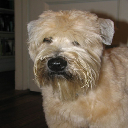

In [7]:
# 샘플 이미지 출력
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

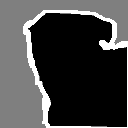

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

###7-2 U-Net 모델(인코더-디코더)

사전 학습된 VGG16모델을 만들어 본본다.
- 데이터 개수가 충분하고 시간이 충분하다는 전전제에서 U-Net 구성하여 학습 진행 가능
- 여기서는 사전 학습된 모델 사용


In [11]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

VGG16모델은 최종 레이어를 제외한 채 불러옴
- 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖음
- 128, 128 크기의 텐서가 마지막 레이어에서는 4,4 크기로 축소 됨
- U-net 인코더 사사용
  - 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
  

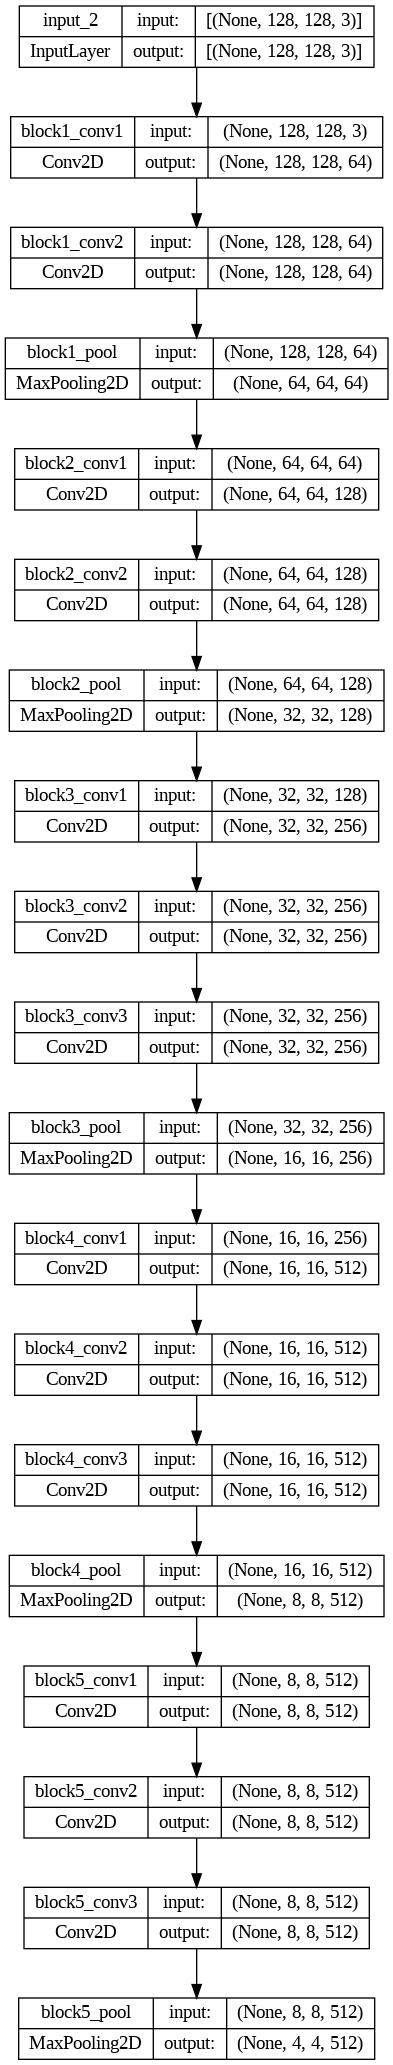

In [12]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

U-net 의 모양을 미리 정하고 사전 학습된 모델에서 어느 부분의 어떤 shape 의 출력을 가져올지 먼저 정함
- VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여 다양한 피처를 추출하는 인코더 모델을 정의
- 여기서는 모델로부터 5개의 출력을 가져와 사용

In [13]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

사전 학습된 파라미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정

In [14]:
# 파라미터 고정
f_model.trainable = False

In [15]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])


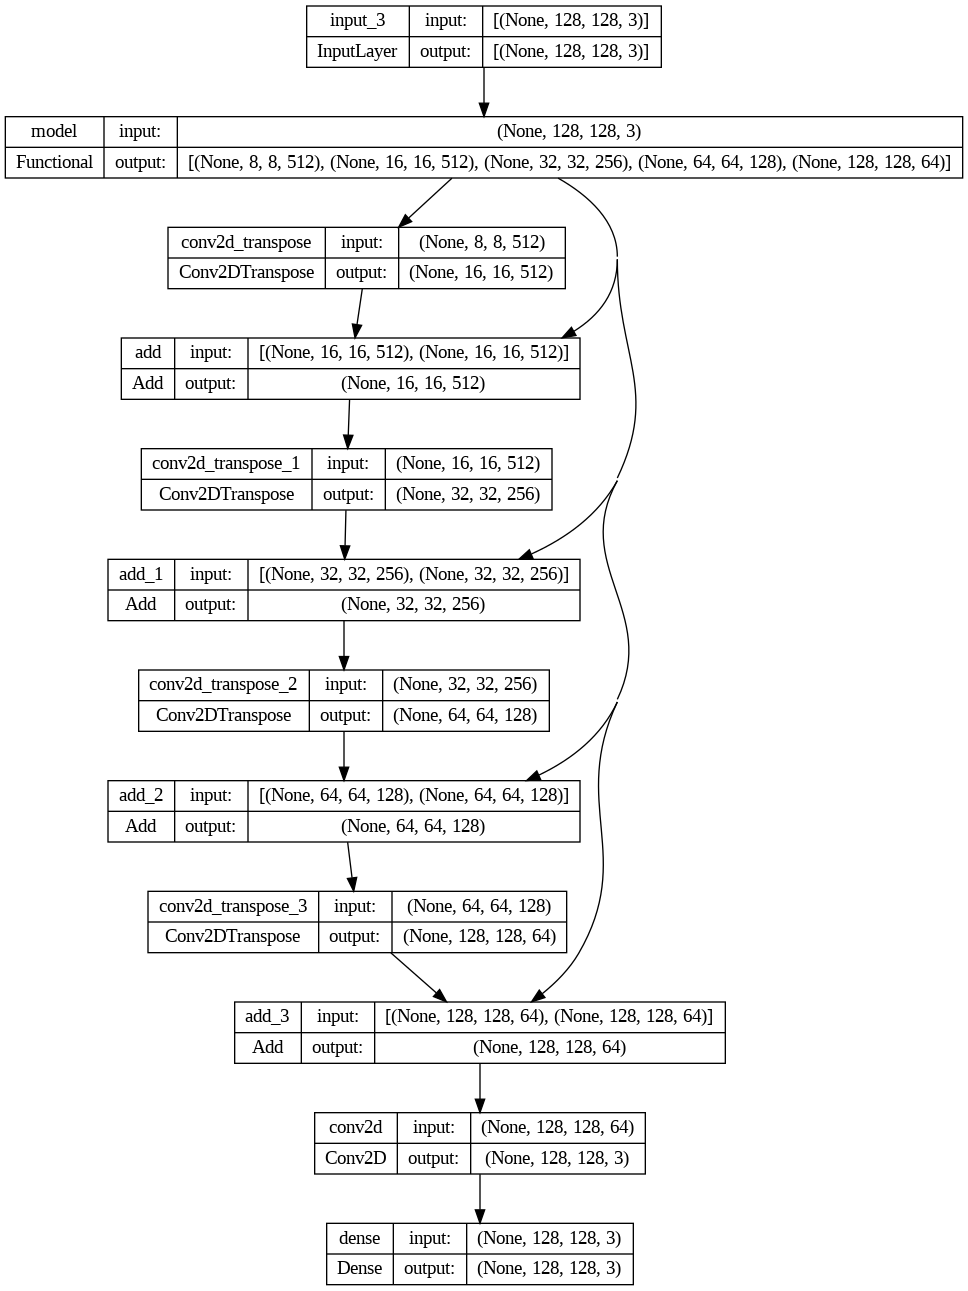

In [16]:

# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)


모델 구조를 요약하면 다음과 같음
- 인코더 출력에 사용하기 위해 f_model 로부터 유래하는 5개 레이어의 14,714,688개의 파라미ㅣ터는 학습되지 않도록 고정

In [17]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_3[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
 68/230 [=======>......................] - ETA: 21:36 - loss: 1.1935 - accuracy: 0.5380

검증 셋의 배치를 하나 선택하고 predict 메소드로 이미지 분할 클래스를 예측

In [ ]:

# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

In [ ]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))